## Homework

---

### Q1

Convert your **Gibbs sampler** from the previous homework to be a **Metropolis within Gibbs** sampler. 
- Do not derive any full conditionals and instead just use the joint distribution which is the product of the likelihood with the priors 
    - Note that in fact you must only be proportional to the joint since irrelevant priors of "the other parameter" will cancel in the ratio
- Note that $\tau$ must be positive so proposals $\tilde \tau$ must also be positive. The easiest way to achieve this would be to use independent samples (that do not depend on $\tau^{(t-1)}$ from exponential, half normal, gamma, or inverse gamma distributions (and other distributions defining strictly positive random variables).
- When considering using independent proposal distributions one option of some note is to use the prior $p(\tau)$ as this proposal distribution

*Clearly articulate your specification and provide a demonstration showing the Bayesian inference it provides, in contrast to that of your previous Gibbs sampler (of Q2 from the last homework).*

### Q2

Adjust your **Metropolis within Gibbs** sampler as follows.

- Use the following **dependent** proposal for $\tau$

```Python
stats.truncnorm(a=-tau_t_minus_1/s, b=np.inf,
                loc=tau_t_minus_1, scale=s)
```

- Use a prior for $\theta$ that is not a normal distribution 


*Provide a demonstration showing the Bayesian inference provided by this sampler. Then discuss the necessity (or lackthereof) of analytically determining the full conditional distributions when performing Gibbs sampling.*

### Q3 

For **Metropolis Hastings** targetting (**stationary distribution**) $p$ based on proposal distribuiton $q$ given below

$\begin{align}
q(\tilde x^{(t)} | x^{(t-1)}) &={} \left(\frac{1}{2}\right)^{1-{\tilde x^{(t)}}}\left(\frac{1}{2}\right)^{\tilde x^{(t)}} \quad \color{gray}{\textrm{ ... does } \quad \frac{q(x^{(t-1)}|\tilde x^{(t)})}{q(\tilde x^{(t)}|x^{(t-1)})} \quad  \textrm{ cancel?}}\\
\textrm{and} \quad p(x^{(t)}) &={} \left(\frac{1}{3}\right)^{1-{x^{(t)}}}\left(\frac{2}{3}\right)^{x^{(t)}}\\
\end{align}$

<u>show that</u> the **transition kernel** $K$ of transition probabilities is defined the **Metropolis Hastings** algorithm is

$K = \left[\begin{array}{cc}\Pr(x^{(t)}=0 \rightarrow x^{(t+1)}=0) & \Pr(x^{(t)}=1 \rightarrow x^{(t+1)}=0)\\\Pr(x^{(t)}=0 \rightarrow x^{(t+1)}=1)& \Pr(x^{(t)}=1 \rightarrow x^{(t+1)}=1)\end{array}\right] = \left[\begin{array}{cl} 0.5 & 0.25 \\ 0.5 & 0.75 \end{array}\right]$

> For example 
>
> $\begin{align}
\Pr(s_1 \rightarrow s_1) &={}
q(\tilde x^{(t)}=1 | x^{(t-1)}=1) + q(\tilde x^{(t)}=0 | x^{(t-1)}=1) \left(1- \frac{p(\tilde x^{(t)}=0)}{p(x^{(t-1)}=1)}\right)\\
&={} 1/2 + (1/2)(1-(1/3)/(2/3)) = 0.75
\end{align}$



This **transition kernel** $K$ means that

- if we're currently a $0$ there's a 50\% chance that we'll stay a $0$ and 50\% chance that we'll change to a $1$
- and if we're currently a $1$ there's a 75\% chance that we'll stay a $1$ and 25\% chance that we'll change to a $0$

which specifies [geometric distributions](https://en.wikipedia.org/wiki/Geometric_distribution) with, respectively, expected values of $1$ and $3$ "failures before transitioning to the other state" which means that on average a "$0$ state" will be a run of two $0$'s while a "$1$ state" will be a run of four $1$'s which leads to the desired one-to-two (or one-thirds to two-thirds) ratio of $0$'s and $1$ is the Markov Chain. 


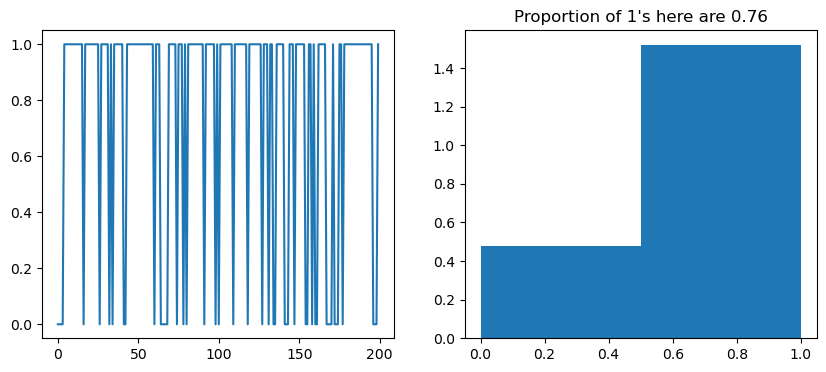

In [22]:
# Here's what it looks like if we flip coins  
# with transition probabilties defind by A sequentially
# and sure enough we recover 1/3 and 2/3 for 0 and 1 respectively
K = np.array([[.5,.25],[.5,.75]]) 
T = 200
s_t = np.zeros(T, dtype=int)
for t in range(1, T):
    s_t[t] = int(stats.uniform().rvs() < K[:,s_t[t-1]][1])
    
fig,ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].plot(s_t)
ax[1].hist(s_t, bins=2, density=True)
ax[1].set_title("Proportion of 1's here are "+str(s_t.mean()));

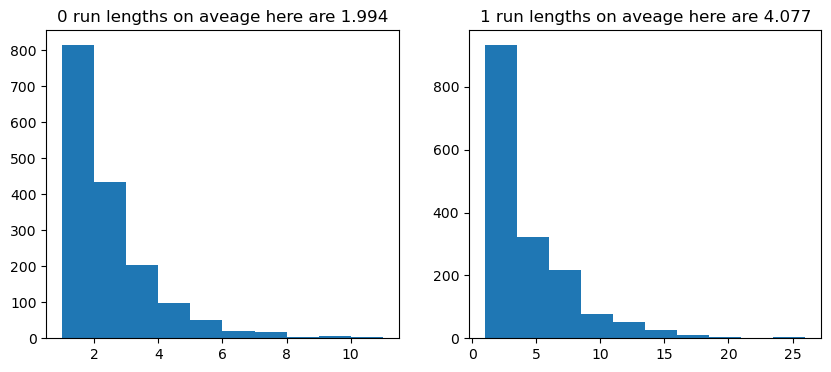

In [23]:
# Here's what it looks like if we flip coins  
# with transition probabilties defind by K 
# and sure enough we recover 1/3 and 2/3 for 0 and 1 respectively
T = 10000
s_t = np.zeros(T, dtype=int)
for t in range(1, T):
    s_t[t] = int(stats.uniform().rvs() < K[:,s_t[t-1]][1])
    
state0_run_length = []
state1_run_length = []
run_length = 1
for t in range(1,T):
    if s_t[t]==s_t[t-1]:
        run_length += 1
    else:
        if s_t[t-1] == 0:
            state0_run_length += [run_length]
        else:
            state1_run_length += [run_length]        
        run_length = 1
        
fig,ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].hist(state0_run_length)
ax[0].set_title("0 run lengths on aveage here are "+str(np.mean(state0_run_length).round(3)))
ax[1].hist(state1_run_length)
ax[1].set_title("1 run lengths on aveage here are "+str(np.mean(state1_run_length).round(3)));


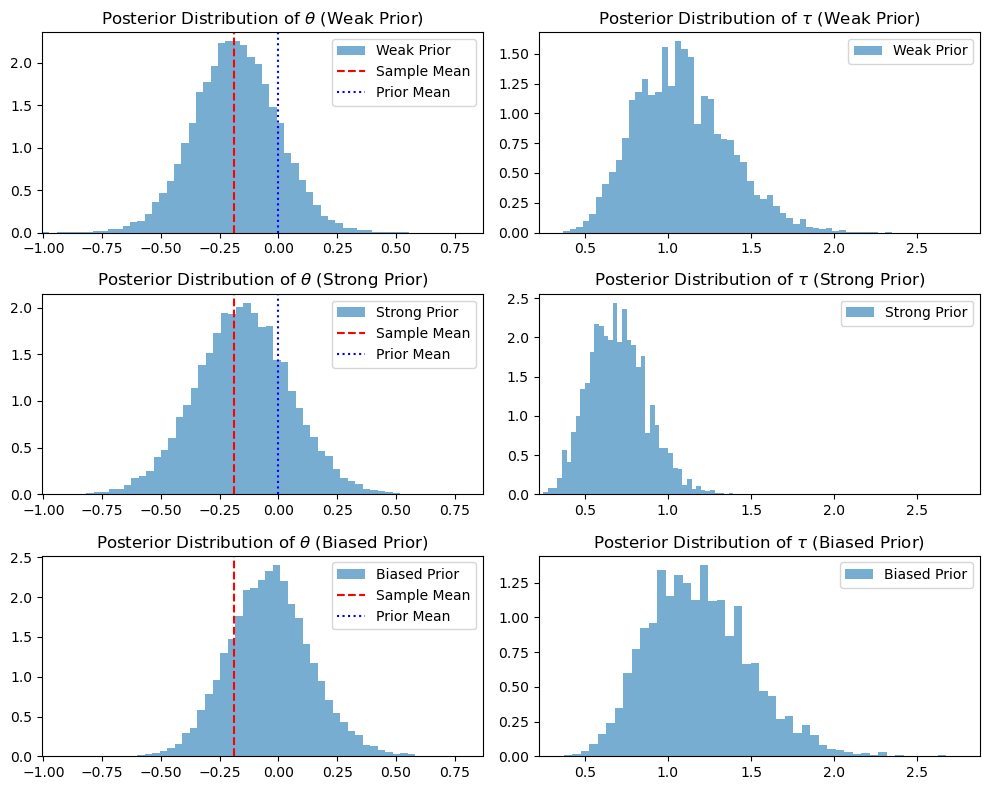

In [24]:
### Question 1 ANSWER ###
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

np.random.seed(42)

n = 30
m = 0
s = 1
x = stats.norm(loc=m, scale=s).rvs(size=n)

C, G = 2, 10000

prior_combinations = [
    {"alpha": 2, "lambda": 2, "theta_0": 0, "tau_0": 1, "label": "Weak Prior"},
    {"alpha": 10, "lambda": 10, "theta_0": 0, "tau_0": 5, "label": "Strong Prior"},
    {"alpha": 2, "lambda": 0.5, "theta_0": 5, "tau_0": 1, "label": "Biased Prior"}
]

samples_theta, samples_tau = [], []

def log_joint_posterior(theta, tau, x, alpha, lambda_, theta_0, tau_0):
    likelihood = np.sum(stats.norm.logpdf(x, loc=theta, scale=1/np.sqrt(tau)))
    prior_theta = stats.norm.logpdf(theta, loc=theta_0, scale=1/np.sqrt(tau_0))
    prior_tau = stats.expon.logpdf(tau, scale=1/lambda_)
    return likelihood + prior_theta + prior_tau

for priors in prior_combinations:
    alpha, lambda_, theta_0, tau_0 = priors["alpha"], priors["lambda"], priors["theta_0"], priors["tau_0"]
    theta, tau = np.zeros([C, G]), np.zeros([C, G])
    theta[:, 0] = 1000
    tau[:, 0] = stats.expon.rvs(scale=1/lambda_, size=C)

    for c in range(C):
        for g in range(1, G):
            mean_theta = (n * x.mean() * tau[c, g-1] + tau_0 * theta_0) / (n * tau[c, g-1] + tau_0)
            std_theta = 1 / np.sqrt((n * tau[c, g-1] + tau_0))
            theta[c, g] = stats.norm.rvs(loc=mean_theta, scale=std_theta)

            tau_current = tau[c, g-1]
            tau_proposed = stats.expon.rvs(scale=2)

            log_alpha = log_joint_posterior(theta[c, g], tau_proposed, x, alpha, lambda_, theta_0, tau_0) - \
                        log_joint_posterior(theta[c, g], tau_current, x, alpha, lambda_, theta_0, tau_0)

            # Accept or reject
            if np.log(np.random.rand()) < log_alpha:
                tau[c, g] = tau_proposed
            else:
                tau[c, g] = tau_current

    samples_theta.append(theta[:, 20:].flatten())
    samples_tau.append(tau[:, 20:].flatten())

theta_min, theta_max = min(map(np.min, samples_theta)), max(map(np.max, samples_theta))
tau_min, tau_max = min(map(np.min, samples_tau)), max(map(np.max, samples_tau))

fig, axes = plt.subplots(len(prior_combinations), 2, figsize=(10, 8))

for idx, priors in enumerate(prior_combinations):
    label = priors["label"]

    # Plot posterior samples of theta
    axes[idx, 0].hist(samples_theta[idx], bins=50, density=True, alpha=0.6, label=label)
    axes[idx, 0].axvline(np.mean(x), color="red", linestyle="--", label="Sample Mean")
    axes[idx, 0].axvline(priors["theta_0"], color="blue", linestyle=":", label="Prior Mean")
    axes[idx, 0].set_xlim(theta_min, theta_max)
    axes[idx, 0].set_title(f"Posterior Distribution of $\\theta$ ({label})")
    axes[idx, 0].legend()

    # Plot posterior samples of tau
    axes[idx, 1].hist(samples_tau[idx], bins=50, density=True, alpha=0.6, label=label)
    axes[idx, 1].set_xlim(tau_min, tau_max)
    axes[idx, 1].set_title(f"Posterior Distribution of $\\tau$ ({label})")
    axes[idx, 1].legend()

plt.tight_layout()
plt.show()


Updated Acceptance Rate for Theta: 0.10
Updated Acceptance Rate for Tau: 0.07


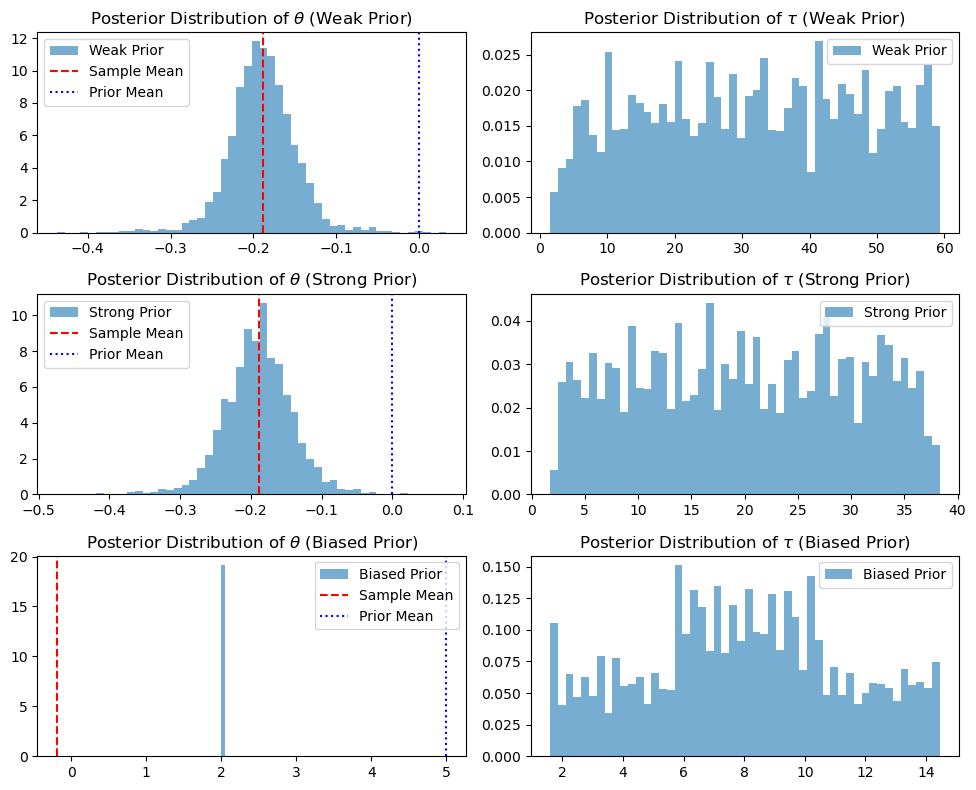

In [30]:
### QUESTION 2 ANSWER
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# Set seed for reproducibility
np.random.seed(42)

# Data generation
n = 30
m = 0
s = 1
x = stats.norm(loc=m, scale=s).rvs(size=n)

# Number of chains and iterations
C, G = 2, 10000  # Increased iterations for better mixing

# Hyperparameters for different priors
prior_combinations = [
    {"alpha": 2, "lambda": 2, "theta_min": -5, "theta_max": 5, "tau_0": 1, "label": "Weak Prior"},
    {"alpha": 10, "lambda": 10, "theta_min": -2, "theta_max": 2, "tau_0": 5, "label": "Strong Prior"},
    {"alpha": 2, "lambda": 0.5, "theta_min": 2, "theta_max": 8, "tau_0": 1, "label": "Biased Prior"}
]

# Storage for posterior samples
samples_theta, samples_tau = [], []

# Define the log joint posterior (up to proportionality)
def log_joint_posterior(theta, tau, x, alpha, lambda_, theta_min, theta_max, tau_0):
    if theta_min <= theta <= theta_max:
        prior_theta = np.log(1 / (theta_max - theta_min))  # Uniform prior
    else:
        return -np.inf  # Assign probability zero if out of bounds

    likelihood = np.sum(stats.norm.logpdf(x, loc=theta, scale=1/np.sqrt(tau)))
    prior_tau = stats.gamma.logpdf(tau, a=alpha, scale=1/lambda_)
    return likelihood + prior_theta + prior_tau

# Metropolis-within-Gibbs Sampler with Adjusted Proposals
for priors in prior_combinations:
    alpha, lambda_, theta_min, theta_max, tau_0 = priors["alpha"], priors["lambda"], priors["theta_min"], priors["theta_max"], priors["tau_0"]
    theta, tau = np.zeros([C, G]), np.zeros([C, G])
    theta[:, 0] = np.random.uniform(theta_min, theta_max, size=C)  # Initial theta sampled from uniform
    tau[:, 0] = stats.gamma.rvs(a=alpha, scale=1/lambda_, size=C)  # Initial tau from prior

    for c in range(C):
        for g in range(1, G):
            # Step 1: Sample theta using a Random Walk proposal
            theta_proposed = theta[c, g-1] + np.random.normal(0, 0.5)  # Small step size

            # Compute acceptance ratio (log-scale for stability)
            log_alpha_theta = log_joint_posterior(theta_proposed, tau[c, g-1], x, alpha, lambda_, theta_min, theta_max, tau_0) - \
                              log_joint_posterior(theta[c, g-1], tau[c, g-1], x, alpha, lambda_, theta_min, theta_max, tau_0)

            if np.log(np.random.rand()) < log_alpha_theta:
                theta[c, g] = theta_proposed  # Accept proposal
            else:
                theta[c, g] = theta[c, g-1]  # Reject, keep previous value

            # Step 2: Metropolis-Hastings for tau with an Adaptive Truncated Normal Proposal
            tau_current = tau[c, g-1]
            scale_tau = np.std(tau[c, max(0, g-500):g]) + 1e-3 if g > 500 else 1  # Use past 500 tau values in the current chain
            tau_proposed = stats.truncnorm.rvs(a=0, b=np.inf, loc=tau_current, scale=scale_tau)

            # Compute acceptance ratio (log-scale for stability)
            log_alpha_tau = log_joint_posterior(theta[c, g], tau_proposed, x, alpha, lambda_, theta_min, theta_max, tau_0) - \
                            log_joint_posterior(theta[c, g], tau_current, x, alpha, lambda_, theta_min, theta_max, tau_0)

            # Accept or reject
            if np.log(np.random.rand()) < log_alpha_tau:
                tau[c, g] = tau_proposed  # Accept proposal
            else:
                tau[c, g] = tau_current  # Reject, keep previous value

    # Store posterior samples
    samples_theta.append(theta[:, 20:].flatten())
    samples_tau.append(tau[:, 20:].flatten())

# Compute new acceptance rates
acceptance_rate_theta = np.mean(samples_theta[0][1:] != samples_theta[0][:-1])
acceptance_rate_tau = np.mean(samples_tau[0][1:] != samples_tau[0][:-1])
print(f"Updated Acceptance Rate for Theta: {acceptance_rate_theta:.2f}")
print(f"Updated Acceptance Rate for Tau: {acceptance_rate_tau:.2f}")

# Plot posterior distributions
fig, axes = plt.subplots(len(prior_combinations), 2, figsize=(10, 8))

for idx, priors in enumerate(prior_combinations):
    label = priors["label"]

    # Plot posterior samples of theta
    axes[idx, 0].hist(samples_theta[idx], bins=50, density=True, alpha=0.6, label=label)
    axes[idx, 0].axvline(np.mean(x), color="red", linestyle="--", label="Sample Mean")
    axes[idx, 0].axvline((priors["theta_min"] + priors["theta_max"]) / 2, color="blue", linestyle=":", label="Prior Mean")
    axes[idx, 0].set_title(f"Posterior Distribution of $\\theta$ ({label})")
    axes[idx, 0].legend()

    # Plot posterior samples of tau
    axes[idx, 1].hist(samples_tau[idx], bins=50, density=True, alpha=0.6, label=label)
    axes[idx, 1].set_title(f"Posterior Distribution of $\\tau$ ({label})")
    axes[idx, 1].legend()

plt.tight_layout()
plt.show()


In [29]:
### Question 3, Please refer to .pdf file in the folder, thanks! ###